In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [12]:
class CNN1D(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3) 
        self.fc1 = nn.Linear(16 * input_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
file_path = "XAUUSD_H1_202201022300_202410252300.csv"
df = pd.read_csv(file_path, delimiter="\t")
data = df['<CLOSE>'].values.astype(float)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

In [14]:
def create_sequences(data, input_seq_length, output_seq_length):
    xs, ys = [], []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        xs.append(data[i:i + input_seq_length])
        ys.append(data[i + input_seq_length:i + input_seq_length + output_seq_length])
    return np.array(xs), np.array(ys)

input_seq_length = 30
output_seq_length = 10
X, y = create_sequences(data_normalized, input_seq_length, output_seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_tensor = torch.Tensor(X_train).unsqueeze(1) 
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test).unsqueeze(1)
y_test_tensor = torch.Tensor(y_test)

X_train_tensor = X_train_tensor.squeeze(-1) 
X_test_tensor = X_test_tensor.squeeze(-1) 

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D(input_size=input_seq_length, output_size=output_seq_length).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) 

In [16]:
epochs = 500
train_losses = []
test_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_outputs = model(X_train_tensor.to(device))
    train_loss = criterion(train_outputs, y_train_tensor.to(device))
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor.to(device))
        test_loss = criterion(test_outputs, y_test_tensor.to(device))
        test_losses.append(test_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}")

model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device)).cpu().numpy()
    test_predictions = model(X_test_tensor.to(device)).cpu().numpy()
    y_train_actual = y_train_tensor.numpy()
    y_test_actual = y_test_tensor.numpy()


Epoch 0/500, Train Loss: 0.27822569012641907, Test Loss: 0.5976272225379944
Epoch 10/500, Train Loss: 0.009915259666740894, Test Loss: 0.6488924026489258
Epoch 20/500, Train Loss: 0.0037180318031460047, Test Loss: 0.34063920378685
Epoch 30/500, Train Loss: 0.0025149229913949966, Test Loss: 0.10453275591135025
Epoch 40/500, Train Loss: 0.001968386583030224, Test Loss: 0.037743471562862396
Epoch 50/500, Train Loss: 0.001506604254245758, Test Loss: 0.01551858987659216
Epoch 60/500, Train Loss: 0.0012757707154378295, Test Loss: 0.020572664216160774
Epoch 70/500, Train Loss: 0.0012409071205183864, Test Loss: 0.0060248346999287605
Epoch 80/500, Train Loss: 0.0011835128534585238, Test Loss: 0.005262605380266905
Epoch 90/500, Train Loss: 0.0011409614235162735, Test Loss: 0.0048953271470963955
Epoch 100/500, Train Loss: 0.0010842543561011553, Test Loss: 0.0036350786685943604
Epoch 110/500, Train Loss: 0.0010748740751296282, Test Loss: 0.00333396065980196
Epoch 120/500, Train Loss: 0.00105508975

In [17]:
r2_train = r2_score(y_train_actual.flatten(), train_predictions.flatten())
r2_test = r2_score(y_test_actual.flatten(), test_predictions.flatten())

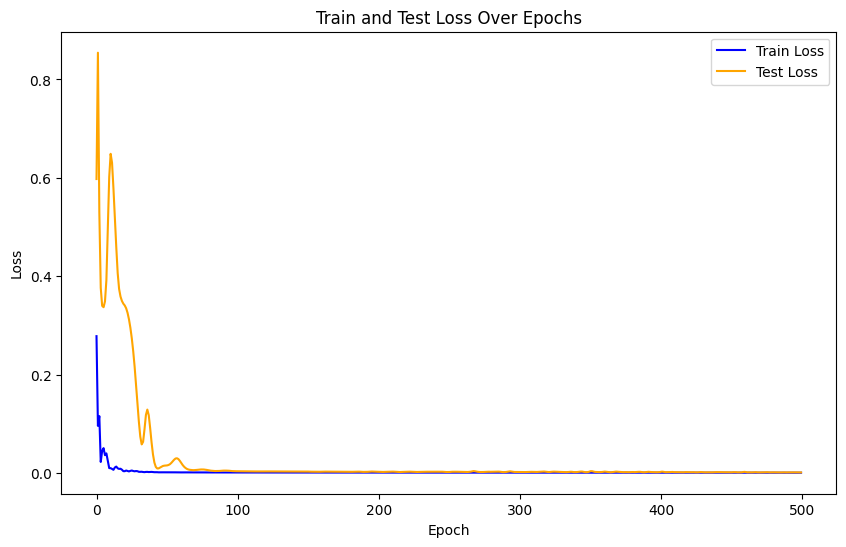

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss", color="blue")
plt.plot(range(epochs), test_losses, label="Test Loss", color="orange")
plt.title("Train and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

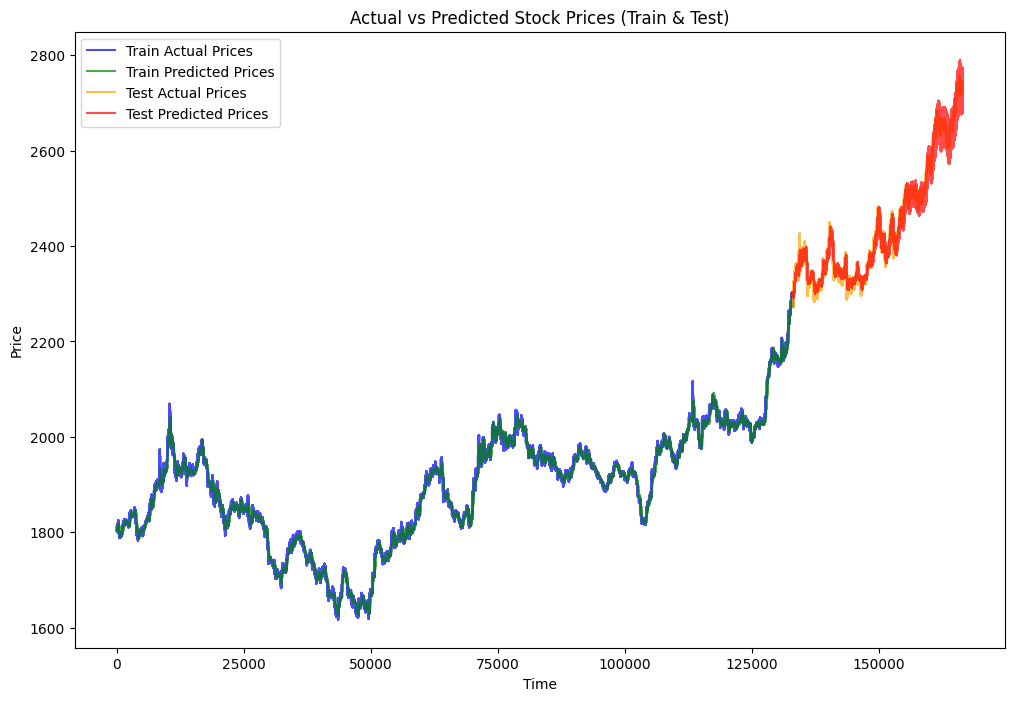

In [19]:
time_train = np.arange(len(y_train_actual.flatten()))
time_test = np.arange(len(y_train_actual.flatten()), len(y_train_actual.flatten()) + len(y_test_actual.flatten()))

plt.figure(figsize=(12, 8))
plt.plot(time_train, scaler.inverse_transform(y_train_actual).flatten(), label="Train Actual Prices", alpha=0.7, color='blue')
plt.plot(time_train, scaler.inverse_transform(train_predictions).flatten(), label="Train Predicted Prices", alpha=0.7, color='green')
plt.plot(time_test, scaler.inverse_transform(y_test_actual).flatten(), label="Test Actual Prices", alpha=0.7, color='orange')
plt.plot(time_test, scaler.inverse_transform(test_predictions).flatten(), label="Test Predicted Prices", alpha=0.7, color='red')
plt.title("Actual vs Predicted Stock Prices (Train & Test)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

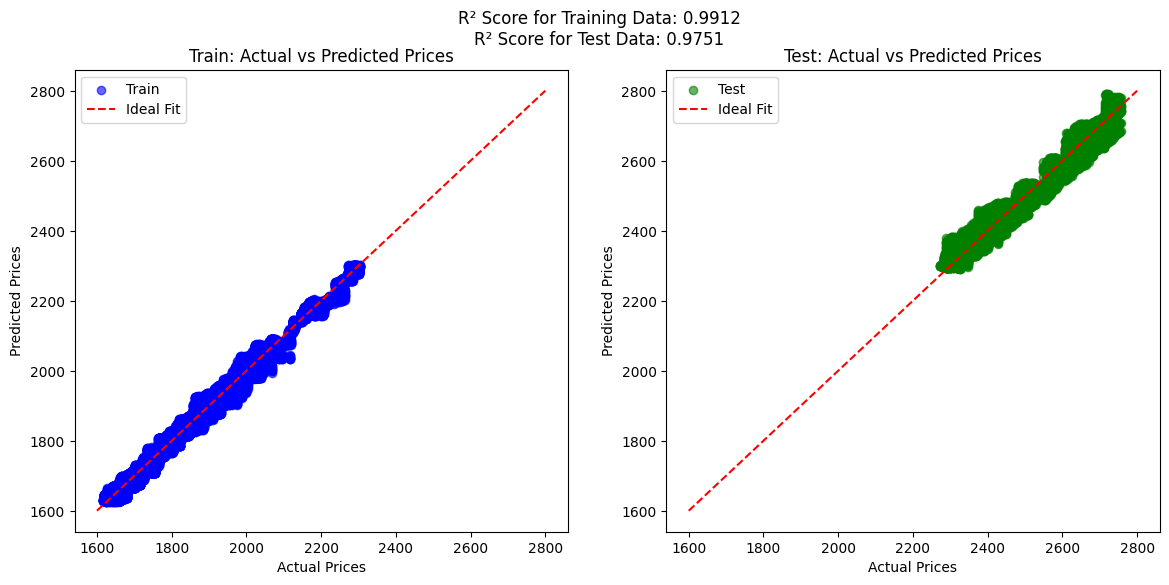

In [20]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(scaler.inverse_transform(y_train_actual).flatten(), scaler.inverse_transform(train_predictions).flatten(), color='blue', alpha=0.6, label="Train")
plt.plot([1600, 2800], [1600, 2800], color='red', linestyle='--', label="Ideal Fit")
plt.title("Train: Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(scaler.inverse_transform(y_test_actual).flatten(), scaler.inverse_transform(test_predictions).flatten(), color='green', alpha=0.6, label="Test")
plt.plot([1600, 2800], [1600, 2800], color='red', linestyle='--', label="Ideal Fit")
plt.title("Test: Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()

plt.suptitle(f"R² Score for Training Data: {r2_train:.4f}\nR² Score for Test Data: {r2_test:.4f}")
plt.show()
